# Setup

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# 读取TF 配置, 防止出现BLAS错误

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# 显示变量的位置是否在GPU
tf.debugging.set_log_device_placement(True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
df = pd.read_csv('airbnb_nyc.csv')

In [6]:
df.shape

(48895, 16)

In [7]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

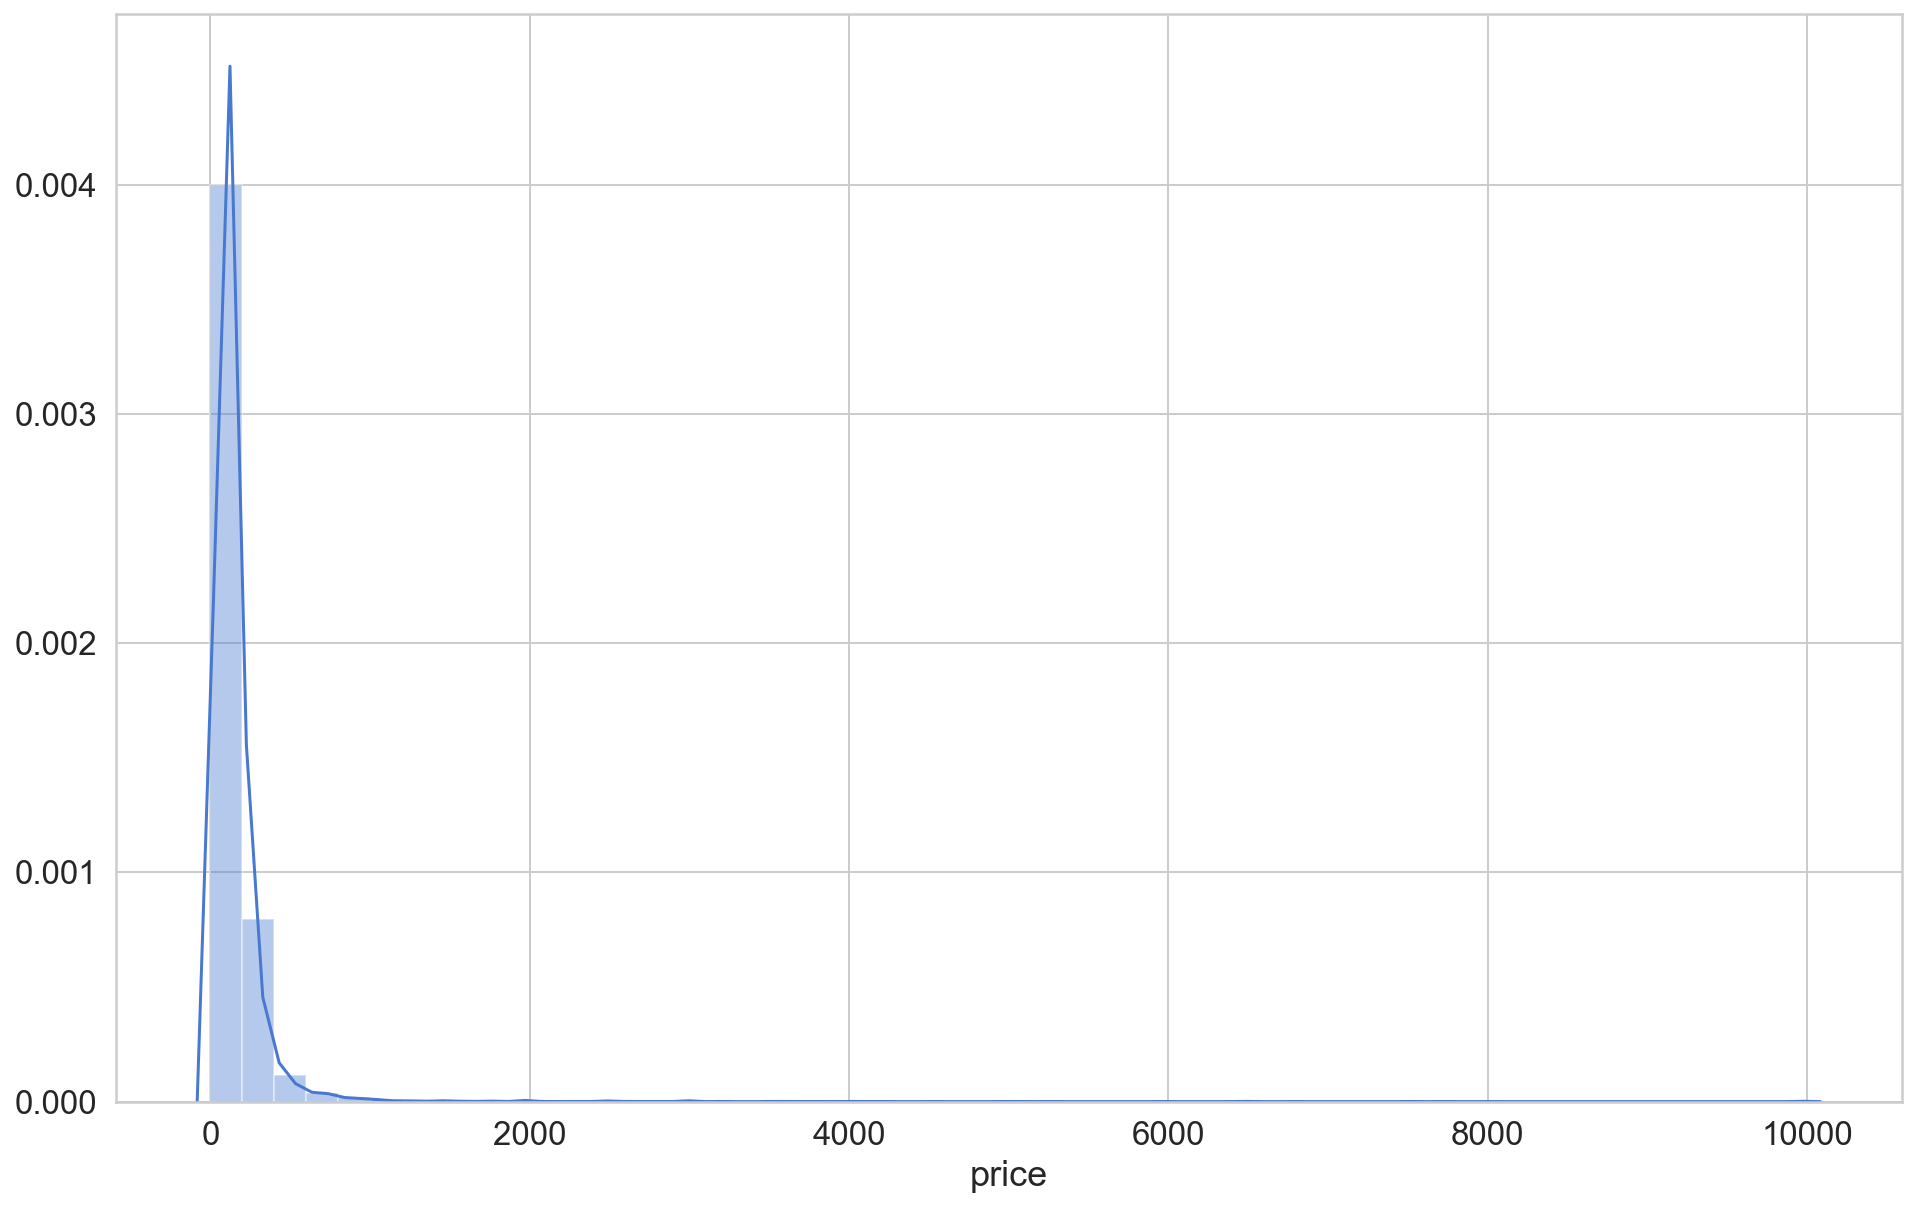

In [8]:
sns.distplot(df.price)

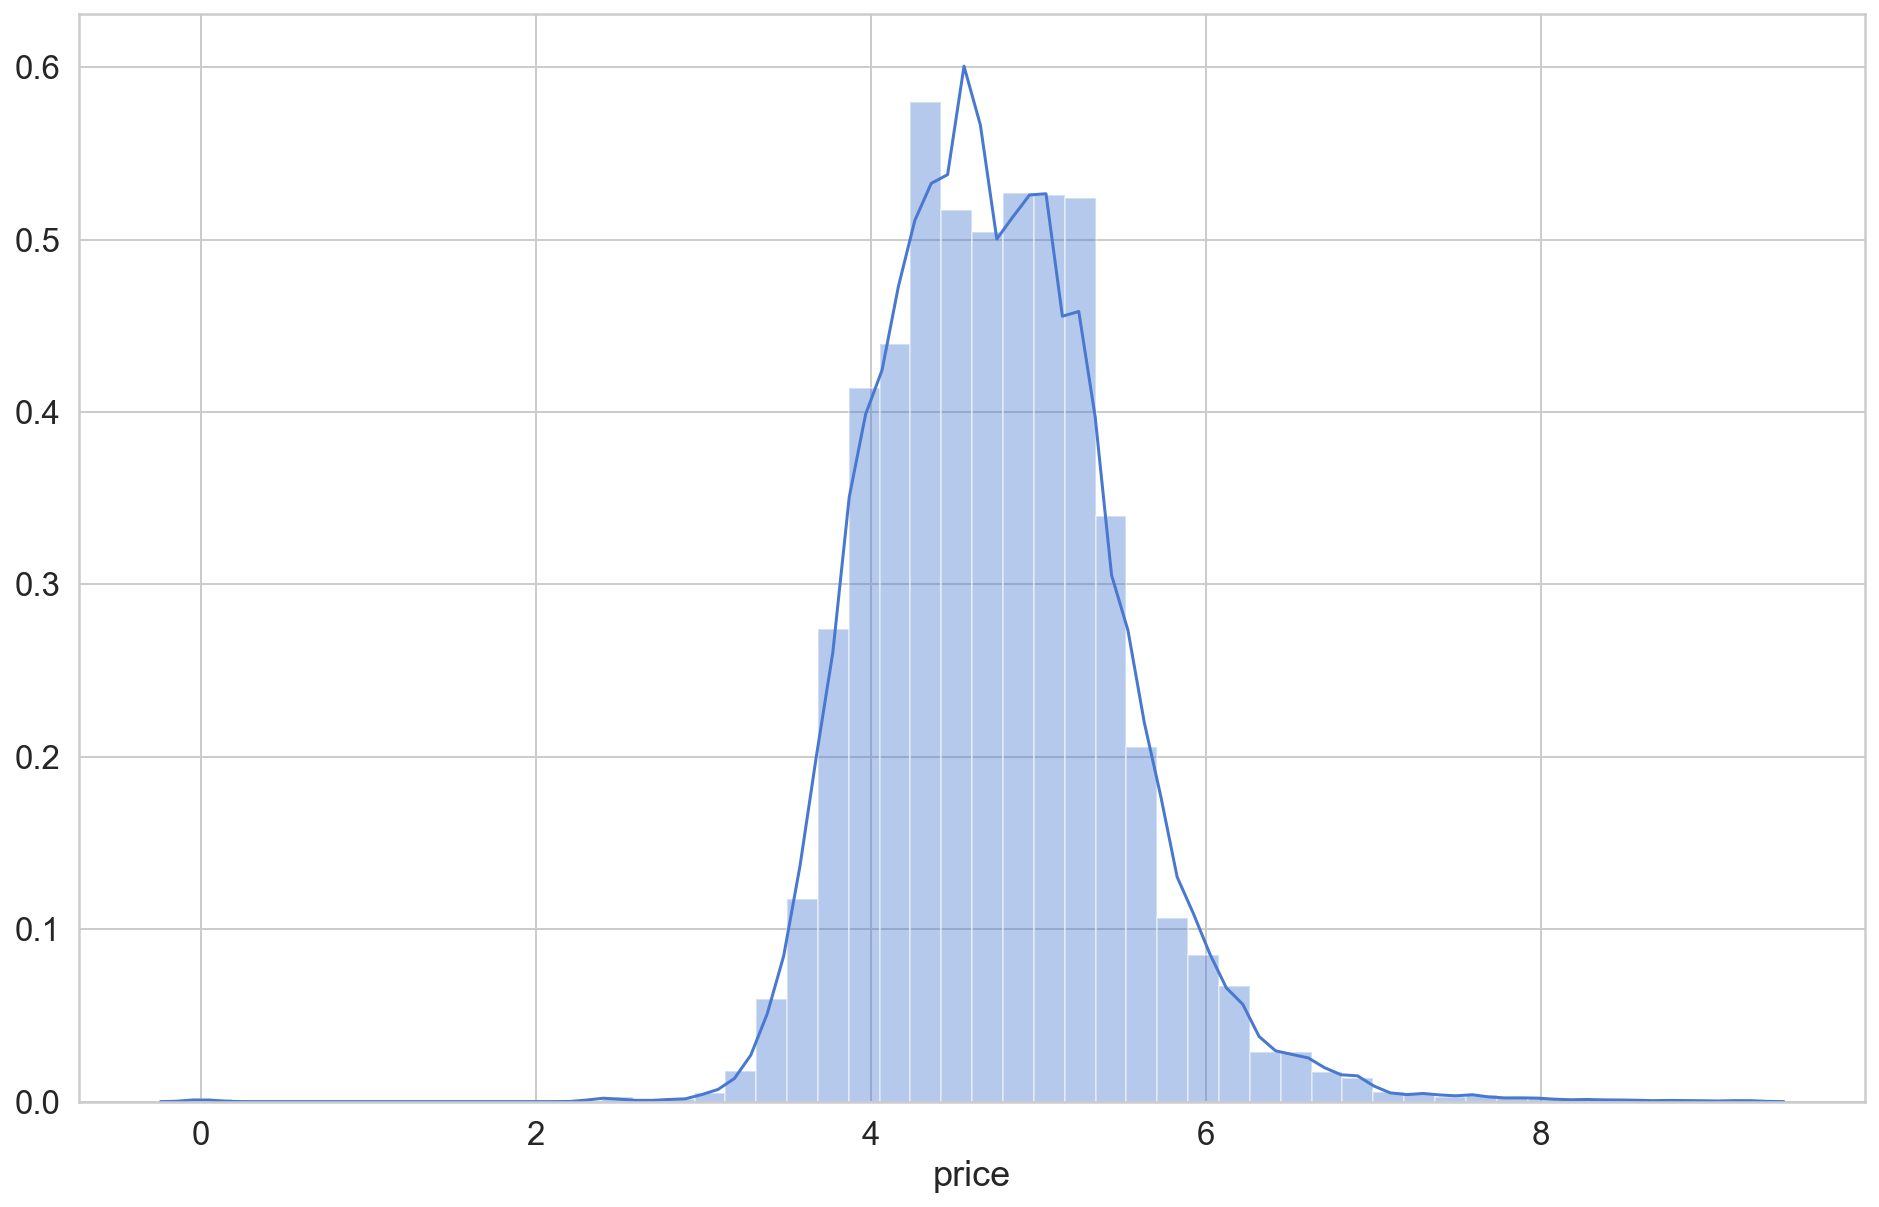

In [9]:
sns.distplot(np.log1p(df.price))

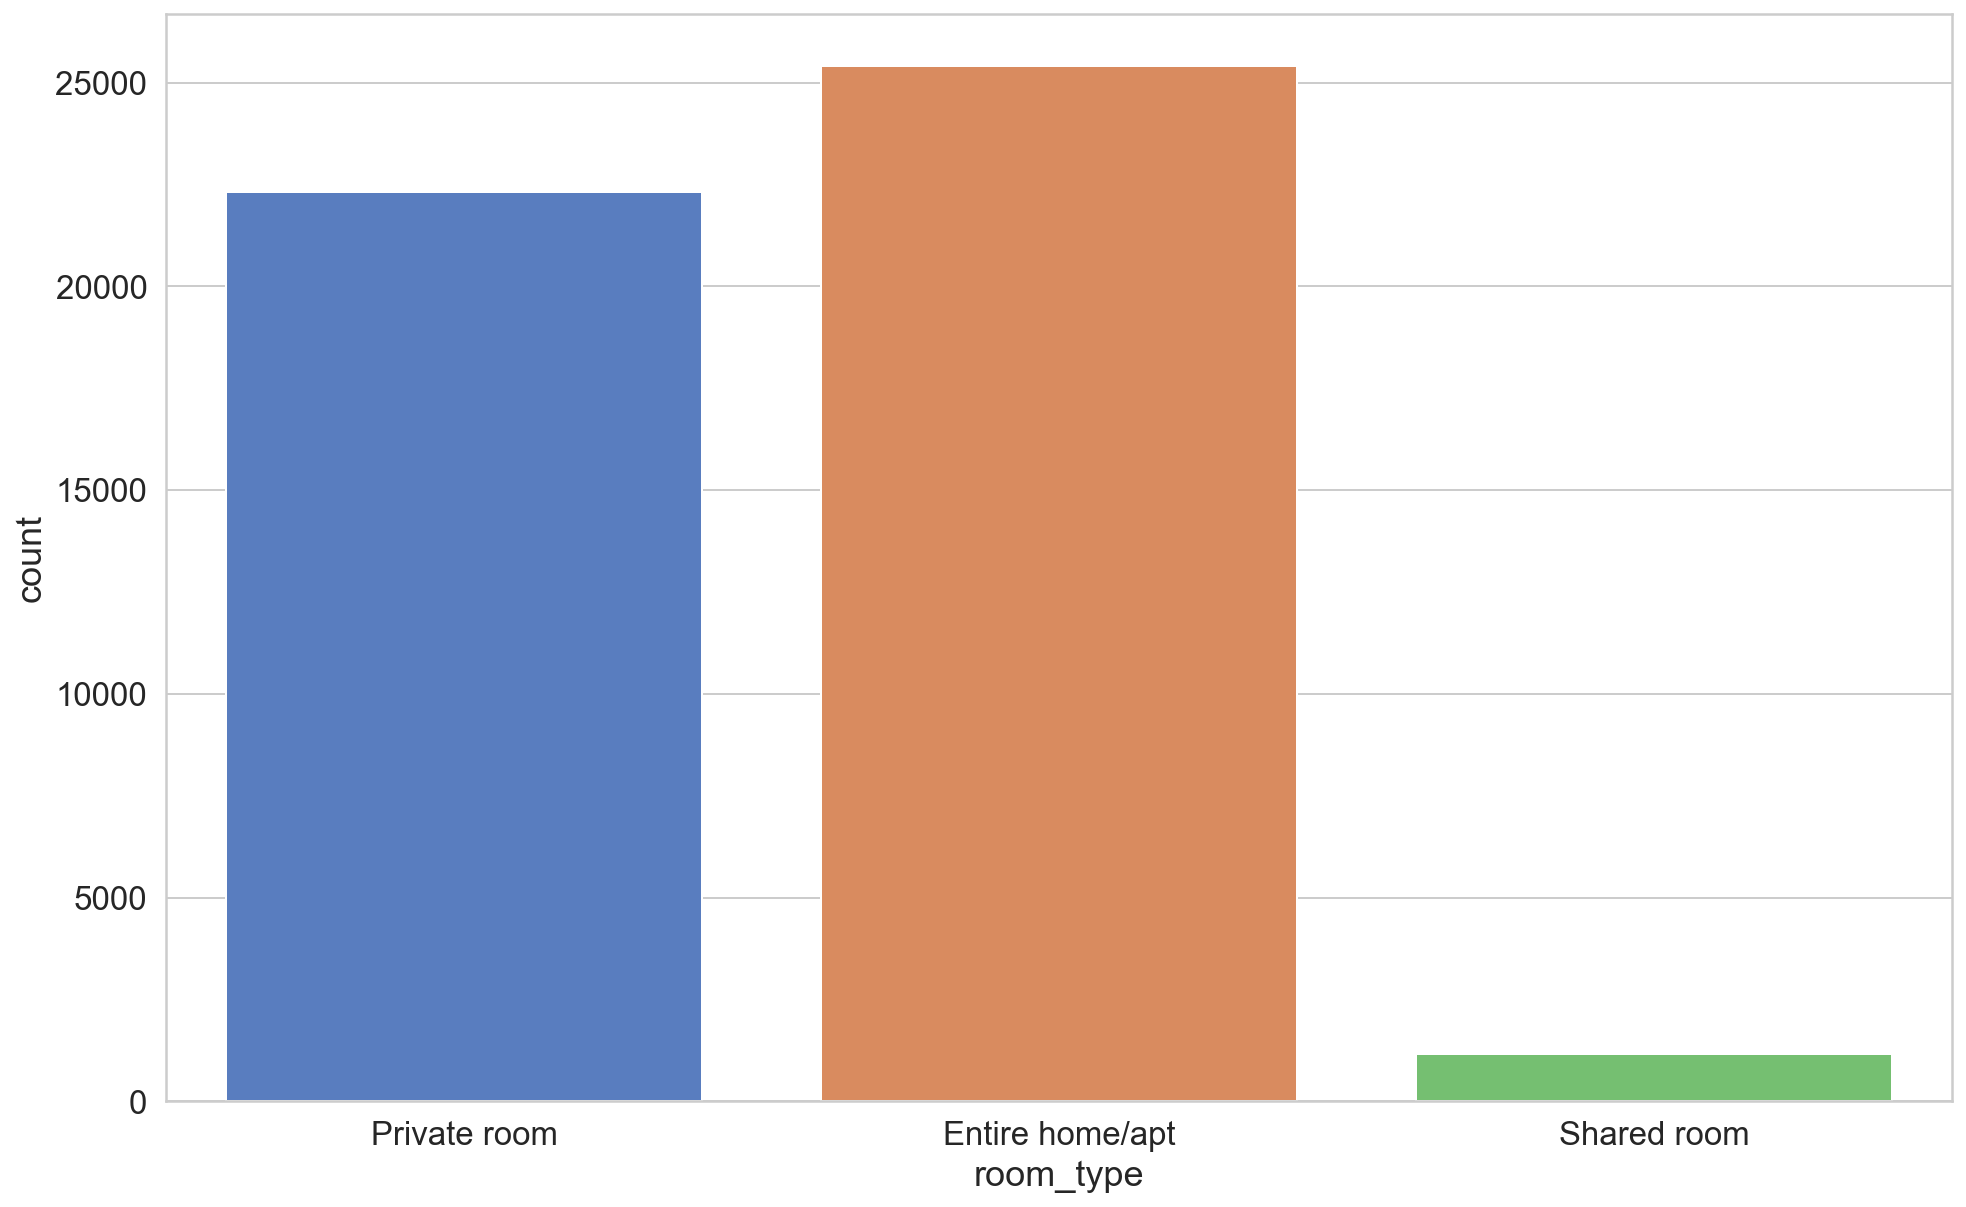

In [10]:
sns.countplot(x='room_type', data=df)

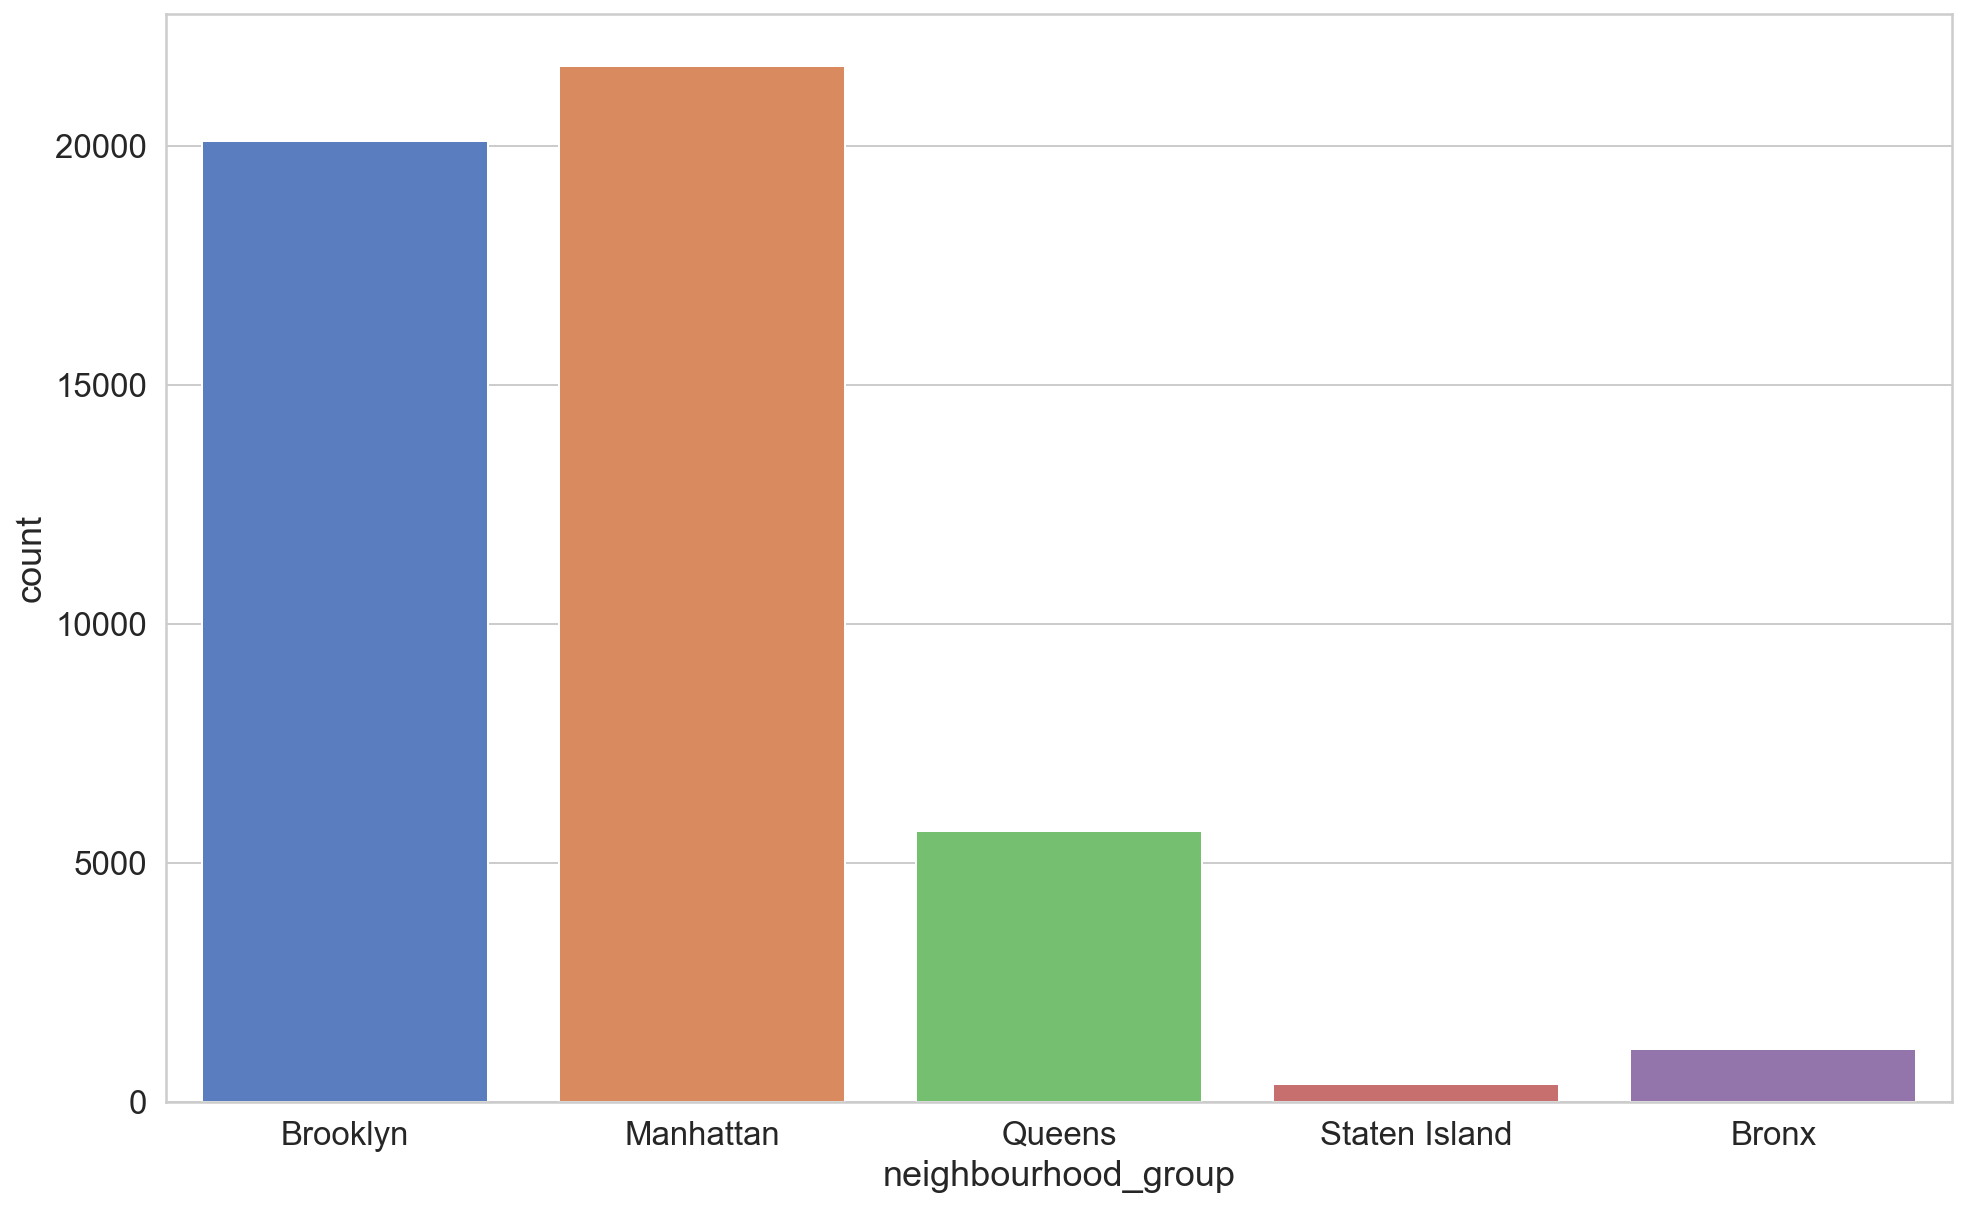

In [11]:
sns.countplot(x='neighbourhood_group', data=df)

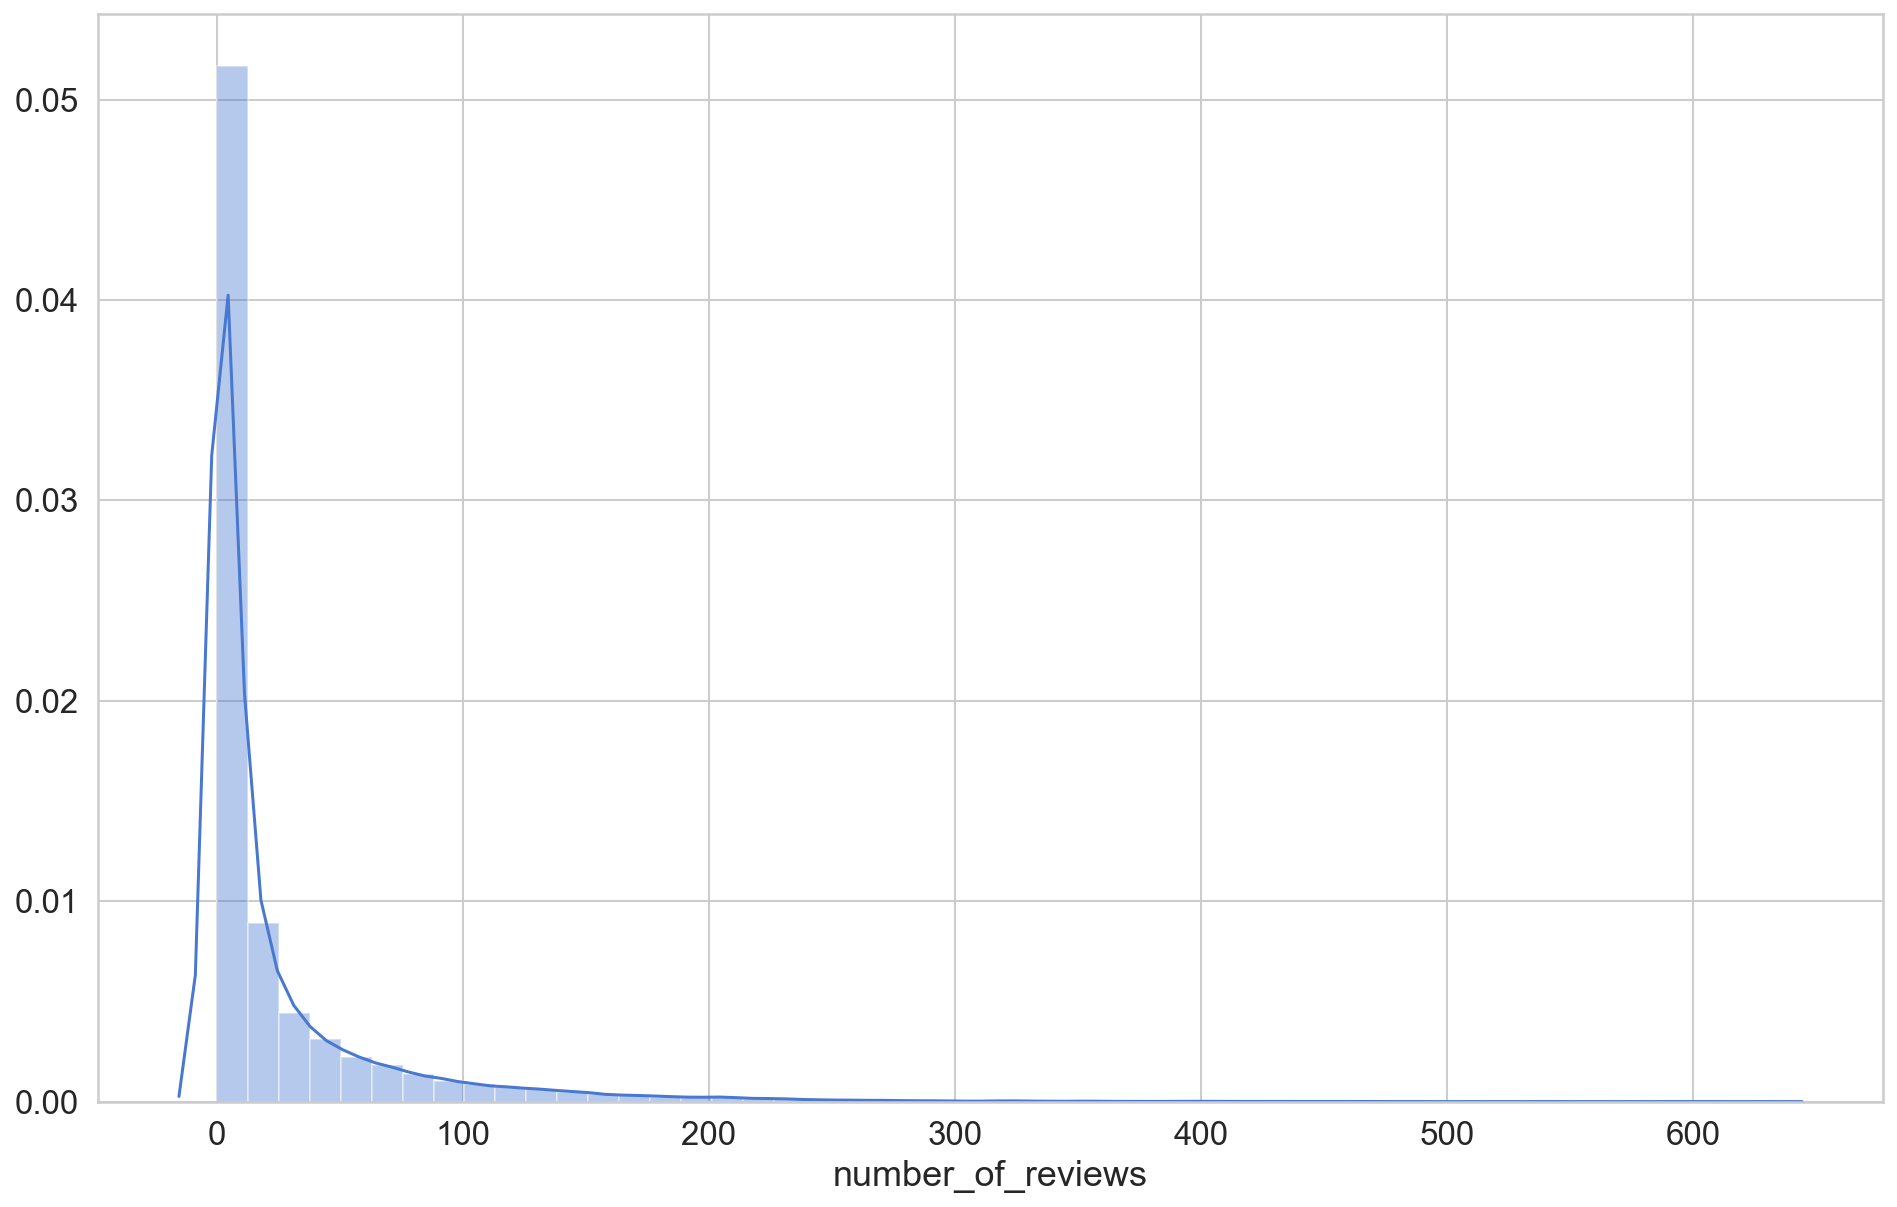

In [12]:
sns.distplot(df.number_of_reviews)

In [13]:
corr_matrix = df.corr()

In [14]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

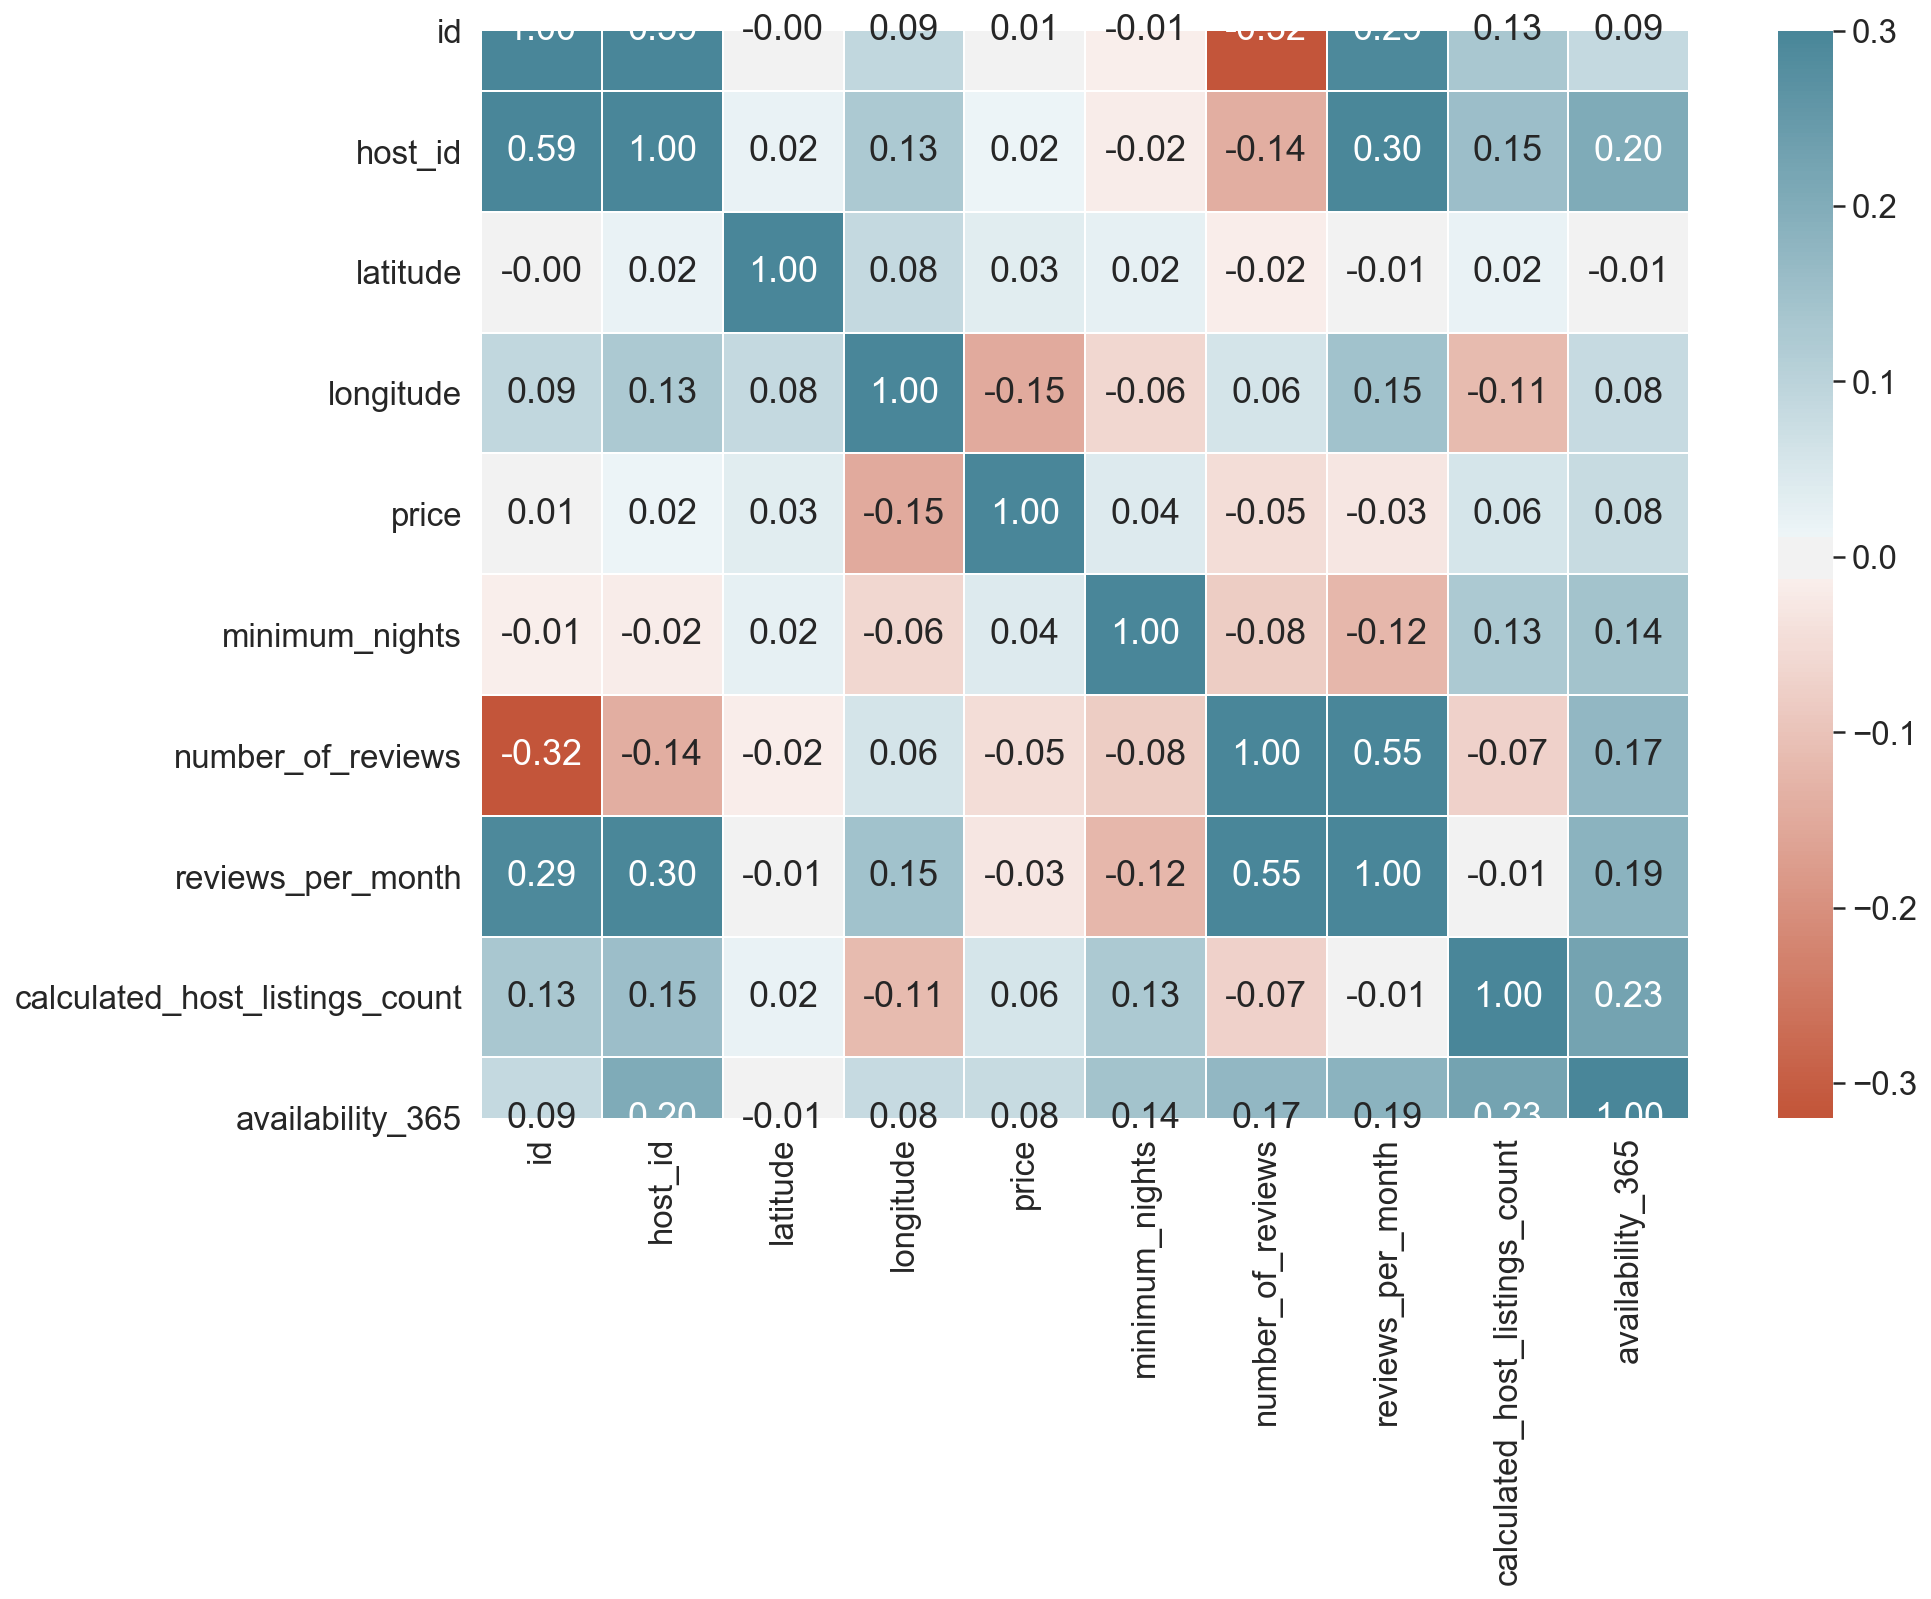

In [15]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

# Prepare Data

## Missing Data

In [16]:
missing = df.isnull().sum()
missing

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [17]:
missing[missing > 0].sort_values(ascending=False)

reviews_per_month    10052
last_review          10052
host_name               21
name                    16
dtype: int64

In [18]:
df = df.drop([
    'id', 'name', 'host_id', 'host_name',
    'reviews_per_month', 'last_review', 'neighbourhood'
], axis=1)

In [19]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [20]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Predict log1p

In [21]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)
print(X.shape, y.shape)

(48895, 8) (48895,)


## Feature scaling and categorical data

In [22]:
from sklearn.preprocessing import OneHotEncoder
data = [['Manhattan'], ['Brooklyn']]
OneHotEncoder(sparse=False).fit_transform(data)

array([[0., 1.],
       [1., 0.]])

In [23]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (MinMaxScaler(), ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']),
    (OneHotEncoder(handle_unknown="ignore"), ['neighbourhood_group', 'room_type'])
)

In [24]:
transformer.fit(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['neighbourhood_group', 'room_type'])],
                  verbose=False)

In [25]:
X = transformer.transform(X)

In [26]:
X[9]

array([0.51697438, 0.47804979, 0.        , 0.25437202, 0.00920245,
       0.51506849, 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        ])

## Split the training and test data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(f'{X_train.shape}, {X_test.shape}, {y_train}, {y_test}')

(39116, 14), (9779, 14), [5.69035945 4.26267988 4.07753744 ... 4.87519732 5.01727984 4.79579055], [4.49980967 3.4339872  4.79579055 ... 4.26267988 6.2166061  4.83628191]


## Modeling

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 31292 samples, validate on 7824 samples
Epoch 1/100
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device 

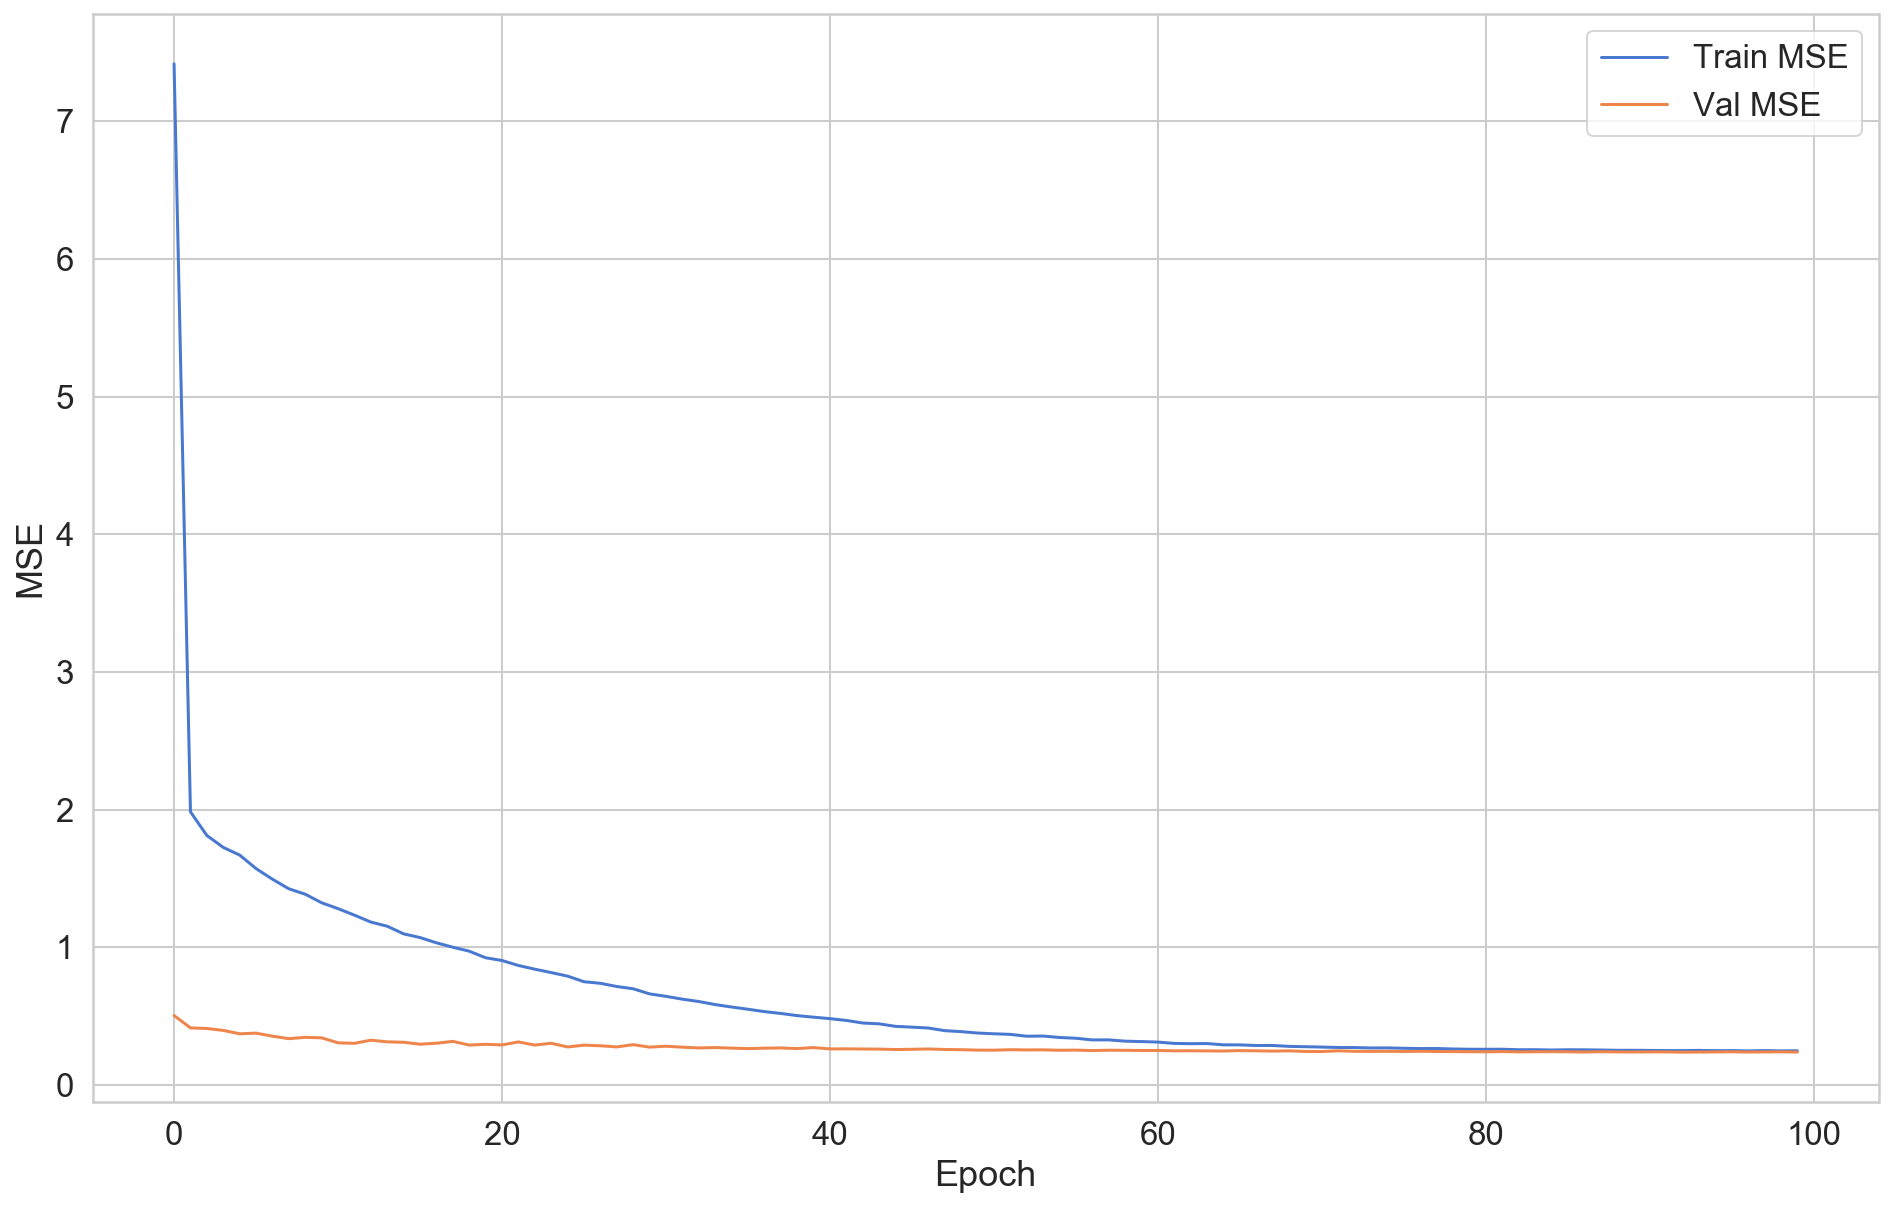

In [29]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='mse',
  mode="min",
  patience=10
)

history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,    
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

plot_mse(history)

# Evaluation

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
f'MSE {mean_squared_error(y_test, y_pred)}'

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_388868 in device /job:localhost/replica:0/task:0/device:GPU:0


'MSE 0.21449616190201856'

In [31]:
f'MAE {mean_absolute_error(y_test, y_pred)}'

'MAE 0.3339302811438184'

In [32]:
f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}'

'RMSE 0.4631373035094653'

In [33]:
f'R2 {r2_score(y_test, y_pred)}'

'R2 0.5466037865416351'

# Save

In [34]:
joblib.dump(transformer, "data_transformer.joblib")
model.save("price_prediction_model.h5")

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
